# Problem 5

## 5-1 : Generate Data

In [4]:
import numpy as np
from sklearn.datasets import make_blobs
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Data generation
n_samples = 2500
random_state = 42
transformation = [[0.6, -0.3], [-0.8, 0.9]]
X, y = make_blobs(n_samples=n_samples, n_features=2, centers=4, cluster_std=1.0,
                  random_state=random_state)
X_aniso = np.dot(X, transformation) * 2 + 10
x = np.vstack([X, X_aniso])

print(f"Dataset shape: {x.shape}")
print(f"Number of samples: {x.shape[0]}")
print(f"Number of features: {x.shape[1]}")

Dataset shape: (5000, 2)
Number of samples: 5000
Number of features: 2


## define GaussianMixtureAnalysis class:

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.stats import multivariate_normal
import seaborn as sns


class GaussianMixtureAnalysis:
    """
    Gaussian Mixture Model analysis with visualization of probability ellipses.
    """

    def __init__(self, data, random_state=42):
        self.data = data
        self.random_state = random_state
        self.models = {}
        self.scores = {}

    def make_ellipses(self, gmm, ax, colors=None):
        """
        Create elliptical patches representing Gaussian components.
        Based on the provided scikit-learn example.
        """
        if colors is None:
            # Generate colors for all possible components
            colors = plt.cm.viridis(np.linspace(0, 1, gmm.n_components))

        for n in range(gmm.n_components):
            if gmm.covariance_type == "full":
                covariances = gmm.covariances_[n][:2, :2]
            elif gmm.covariance_type == "tied":
                covariances = gmm.covariances_[:2, :2]
            elif gmm.covariance_type == "diag":
                covariances = np.diag(gmm.covariances_[n][:2])
            elif gmm.covariance_type == "spherical":
                covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]

            v, w = np.linalg.eigh(covariances)
            u = w[0] / np.linalg.norm(w[0])
            angle = np.arctan2(u[1], u[0])
            angle = 180 * angle / np.pi  # convert to degrees
            v = 2.0 * np.sqrt(2.0) * np.sqrt(v)

            ell = mpl.patches.Ellipse(
                gmm.means_[n, :2], v[0], v[1],
                angle=180 + angle,
                color=colors[n],
                alpha=0.5
            )
            ell.set_clip_box(ax.bbox)
            ax.add_artist(ell)

    def fit_gmm_range(self, n_components_range, covariance_type='full'):
        """
        Fit GMM models for a range of component numbers.
        """
        for n_components in n_components_range:
            gmm = GaussianMixture(
                n_components=n_components,
                covariance_type=covariance_type,
                random_state=self.random_state,
                n_init=10,
                max_iter=100
            )
            gmm.fit(self.data)

            # Calculate scores
            labels = gmm.predict(self.data)

            # Store model and scores
            self.models[n_components] = gmm
            self.scores[n_components] = {
                'bic': gmm.bic(self.data),
                'aic': gmm.aic(self.data),
                'log_likelihood': gmm.score(self.data) * len(self.data)
            }

            # Add silhouette score if we have more than 1 component
            if n_components > 1:
                self.scores[n_components]['silhouette'] = silhouette_score(
                    self.data, labels)
            else:
                self.scores[n_components]['silhouette'] = -1

    def plot_gmm_components(self, n_components_range):
        """
        Plot GMM results for different numbers of components.
        """
        n_plots = len(n_components_range)
        n_cols = 5
        n_rows = int(np.ceil(n_plots / n_cols))

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
        axes = axes.flatten() if n_plots > 1 else [axes]

        for idx, n_components in enumerate(n_components_range):
            ax = axes[idx]
            gmm = self.models[n_components]

            # Plot data points
            labels = gmm.predict(self.data)
            scatter = ax.scatter(
                self.data[:, 0],
                self.data[:, 1],
                c=labels,
                cmap='viridis',
                s=10,
                alpha=0.6
            )

            # Add ellipses
            self.make_ellipses(gmm, ax)

            # Add cluster centers
            ax.scatter(
                gmm.means_[:, 0],
                gmm.means_[:, 1],
                c='red',
                marker='x',
                s=100,
                linewidths=2,
                label='Centers'
            )

            ax.set_title(
                f'GMM with {n_components} components\nBIC: {self.scores[n_components]["bic"]:.1f}')
            ax.set_xlabel('Feature 1')
            ax.set_ylabel('Feature 2')
            ax.set_aspect('equal', 'datalim')

        # Hide unused subplots
        for idx in range(n_plots, len(axes)):
            axes[idx].set_visible(False)

        plt.tight_layout()
        plt.show()

    def plot_model_selection_criteria(self):
        """
        Plot BIC, AIC, and silhouette scores for model selection.
        """
        n_components = list(self.scores.keys())
        bic_scores = [self.scores[n]['bic'] for n in n_components]
        aic_scores = [self.scores[n]['aic'] for n in n_components]
        silhouette_scores = [self.scores[n]['silhouette']
                             for n in n_components]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # BIC and AIC
        ax1.plot(n_components, bic_scores, 'bo-', label='BIC', markersize=8)
        ax1.plot(n_components, aic_scores, 'ro-', label='AIC', markersize=8)
        ax1.set_xlabel('Number of Components')
        ax1.set_ylabel('Information Criterion')
        ax1.set_title('Model Selection: BIC and AIC')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Find and mark the minimum BIC
        min_bic_idx = np.argmin(bic_scores)
        ax1.axvline(x=n_components[min_bic_idx],
                    color='blue', linestyle='--', alpha=0.5)
        ax1.text(n_components[min_bic_idx], max(bic_scores),
                 f'Best: {n_components[min_bic_idx]}', ha='center')

        # Silhouette scores
        ax2.plot(n_components, silhouette_scores, 'go-', markersize=8)
        ax2.set_xlabel('Number of Components')
        ax2.set_ylabel('Silhouette Score')
        ax2.set_title('Model Selection: Silhouette Score')
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        return n_components[min_bic_idx]

    def plot_density_contours(self, n_components):
        """
        Plot density contours for the selected GMM model.
        """
        gmm = self.models[n_components]

        # Create a mesh
        x_min, x_max = self.data[:, 0].min() - 1, self.data[:, 0].max() + 1
        y_min, y_max = self.data[:, 1].min() - 1, self.data[:, 1].max() + 1

        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, 100),
            np.linspace(y_min, y_max, 100)
        )

        # Calculate probabilities
        positions = np.vstack([xx.ravel(), yy.ravel()]).T
        log_prob = gmm.score_samples(positions)
        prob = np.exp(log_prob).reshape(xx.shape)

        # Plot
        plt.figure(figsize=(10, 8))

        # Contour plot
        contour = plt.contour(xx, yy, prob, levels=10,
                              colors='black', alpha=0.4)
        plt.clabel(contour, inline=True, fontsize=8)

        # Filled contour
        plt.contourf(xx, yy, prob, levels=20, cmap='YlOrRd', alpha=0.6)

        # Data points
        labels = gmm.predict(self.data)
        scatter = plt.scatter(
            self.data[:, 0],
            self.data[:, 1],
            c=labels,
            cmap='viridis',
            s=30,
            alpha=0.8,
            edgecolors='black',
            linewidth=0.5
        )

        # Component centers
        plt.scatter(
            gmm.means_[:, 0],
            gmm.means_[:, 1],
            c='red',
            marker='*',
            s=300,
            edgecolors='black',
            linewidth=2,
            label='Component Centers'
        )

        plt.colorbar(scatter, label='Component Assignment')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.title(f'GMM Density Contours ({n_components} components)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def analyze_component_weights(self):
        """
        Analyze and visualize component weights for all models.
        """
        fig, ax = plt.subplots(figsize=(12, 6))

        for n_comp in sorted(self.models.keys()):
            gmm = self.models[n_comp]
            weights = gmm.weights_

            # Create x positions for bars
            x_pos = np.arange(len(weights)) + n_comp * 0.1

            ax.bar(x_pos, weights, width=0.08,
                   label=f'{n_comp} comp', alpha=0.8)

        ax.set_xlabel('Component Index')
        ax.set_ylabel('Weight')
        ax.set_title('Component Weights for Different GMM Models')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


## 5-2

Starting Gaussian Mixture Model Analysis...
Fitting GMM models for components 1 to 10...

Plotting GMM results for different numbers of components...


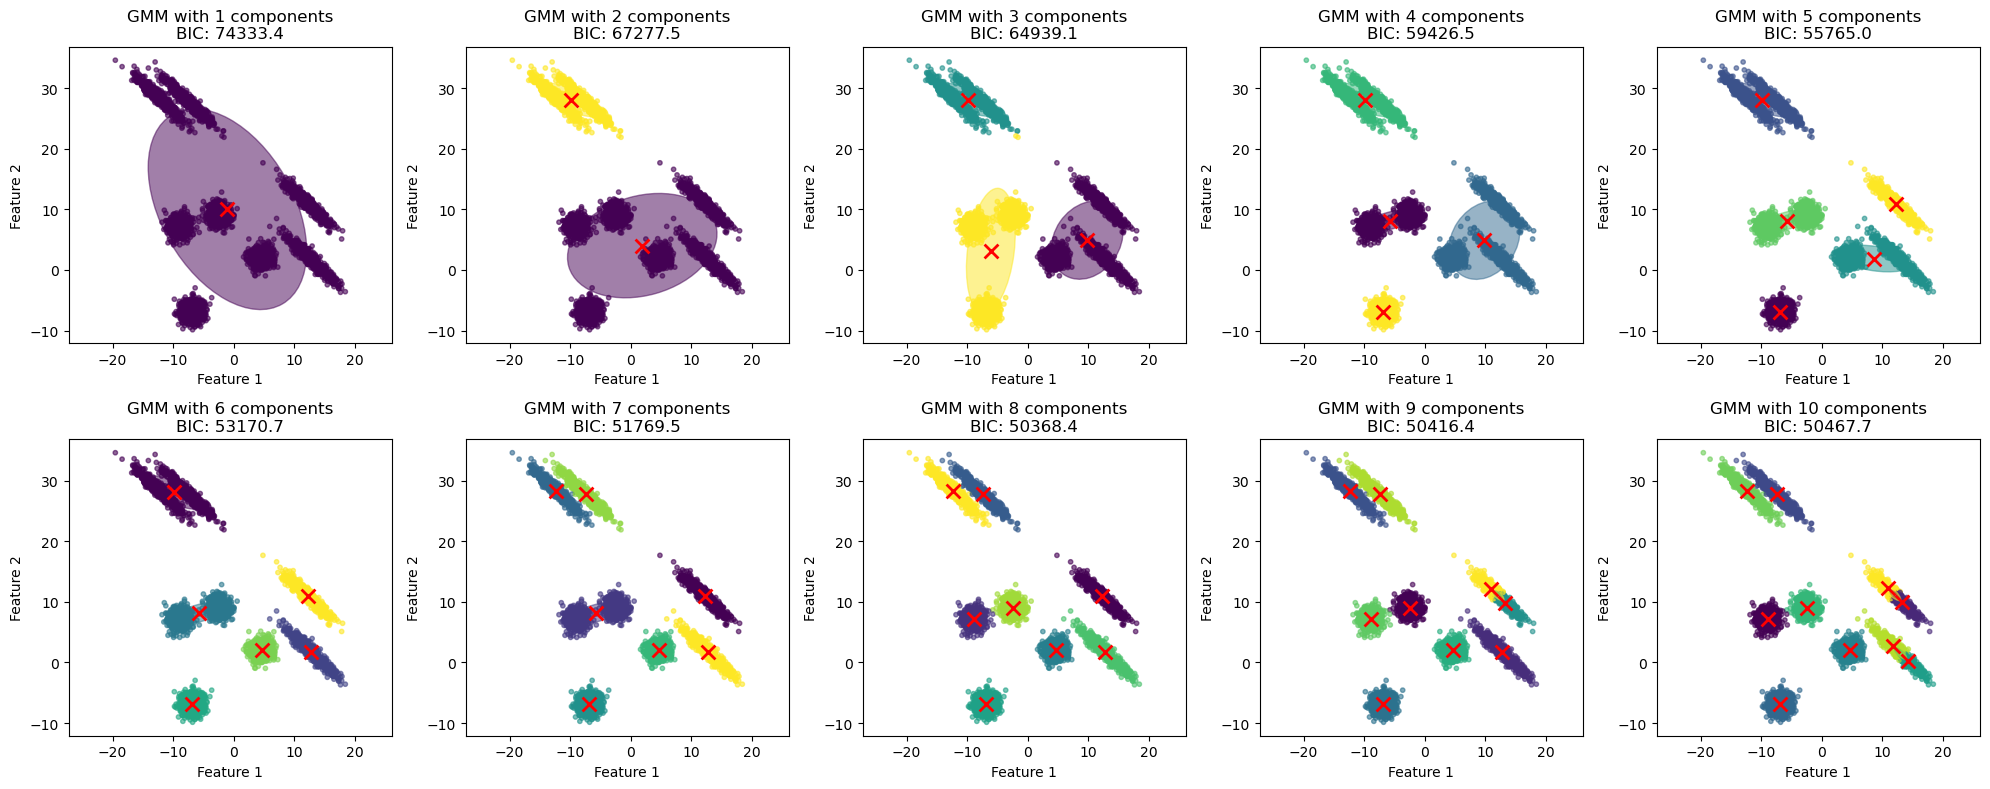

In [ ]:
# Run the analysis
print("Starting Gaussian Mixture Model Analysis...")
print("="*60)

# Initialize analyzer
gmm_analyzer = GaussianMixtureAnalysis(x, random_state=42)

# Define range of components
n_components_range = range(1, 11)  # 1 to 10 components

# Fit GMM models
print("Fitting GMM models for components 1 to 10...")
gmm_analyzer.fit_gmm_range(n_components_range)

# Plot results similar to Figure 5-1
print("\nPlotting GMM results for different numbers of components...")
gmm_analyzer.plot_gmm_components(n_components_range)

## 5-3

Starting Gaussian Mixture Model Analysis...
Fitting GMM models for components 1 to 20...

Plotting GMM results for different numbers of components...


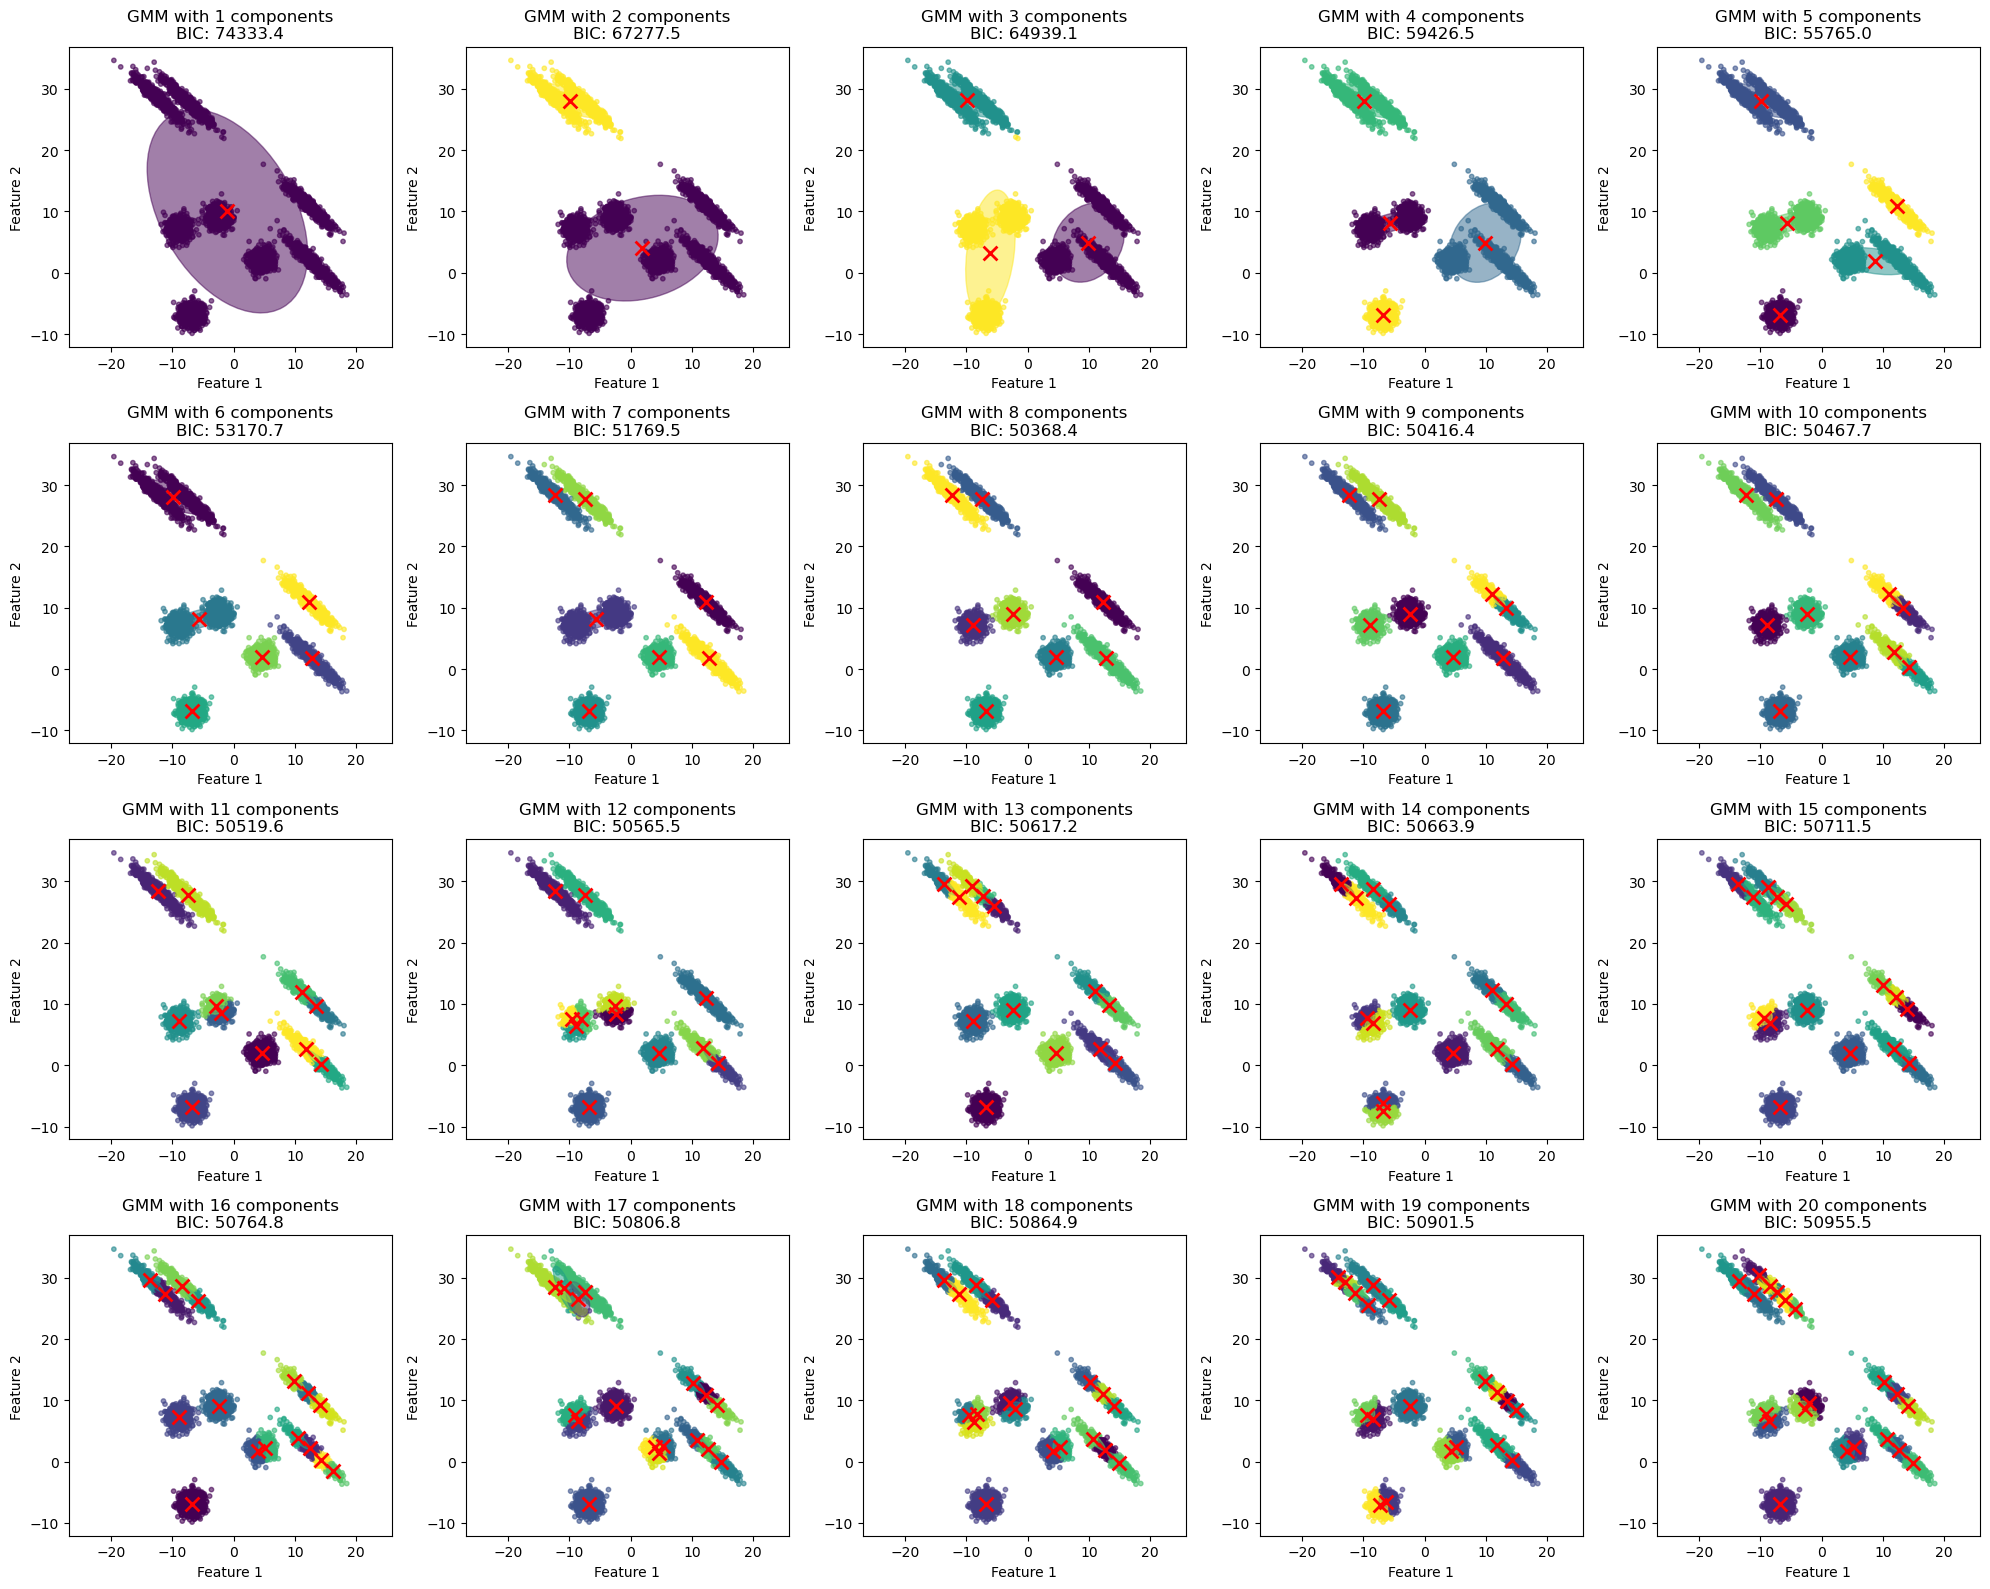


Plotting model selection criteria...


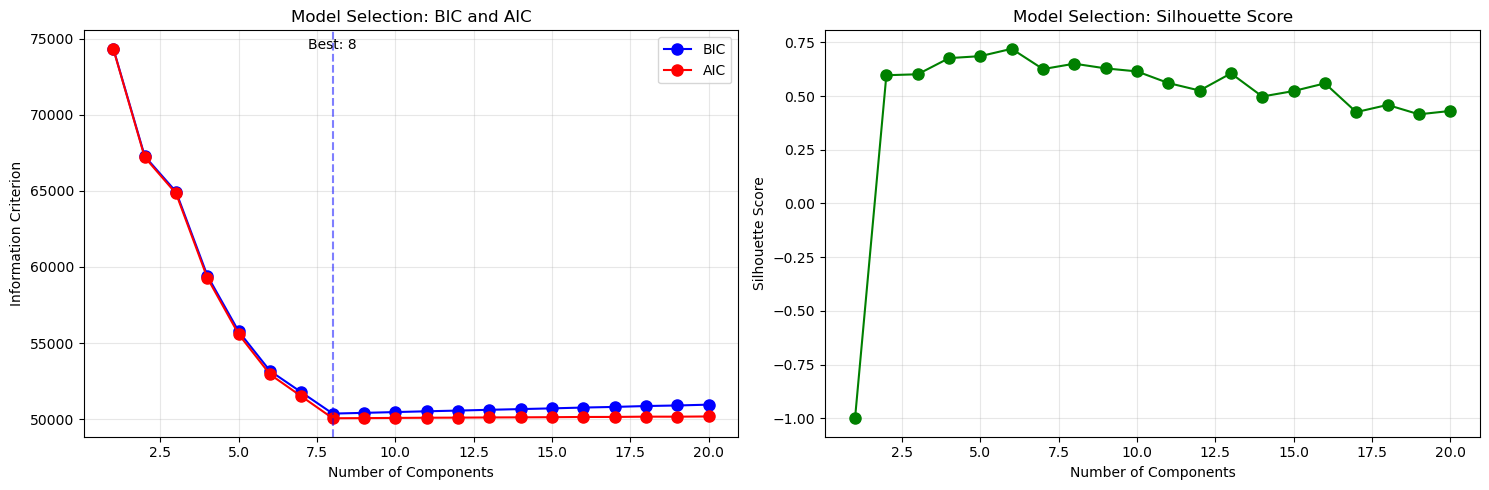


Optimal number of components based on BIC: 8

Plotting density contours for 8 components...


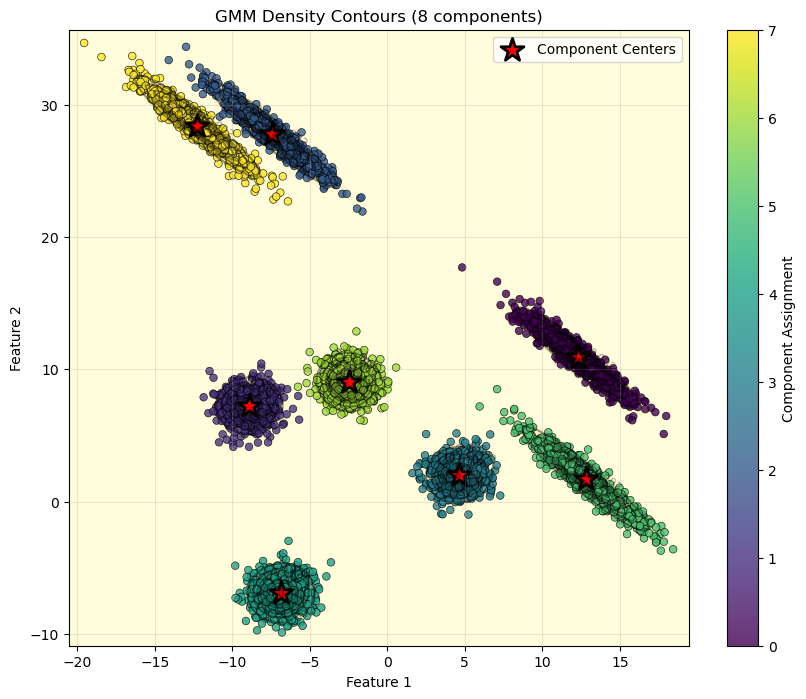


Analyzing component weights...


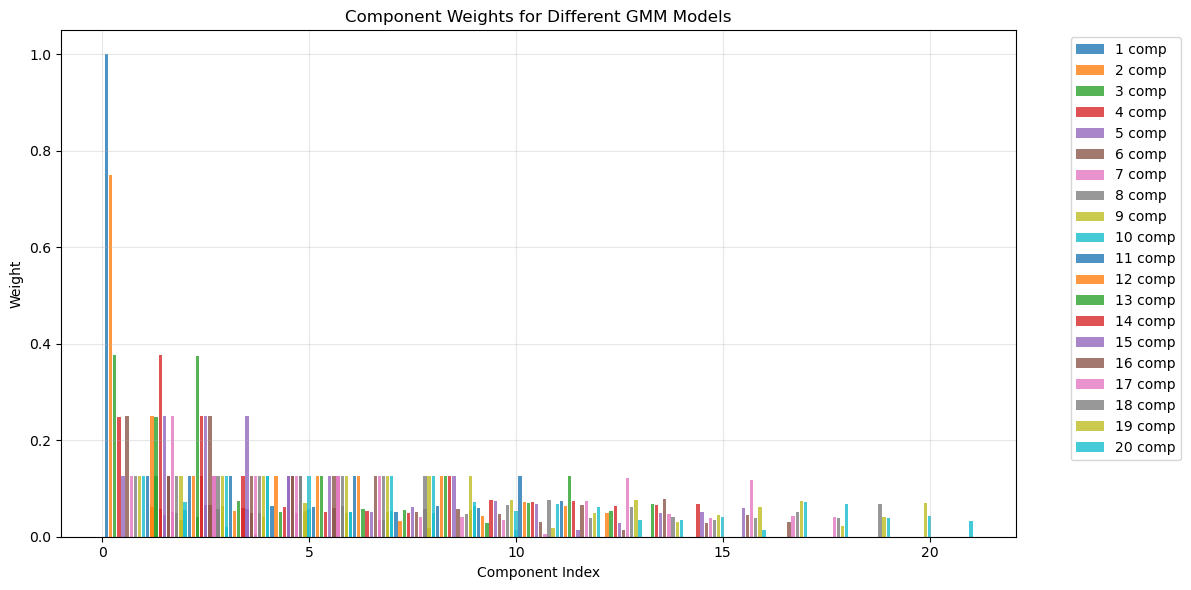

In [ ]:
# Run the analysis
print("Starting Gaussian Mixture Model Analysis...")
print("="*60)

# Initialize analyzer
gmm_analyzer = GaussianMixtureAnalysis(x, random_state=42)

# Define range of components
n_components_range = range(1, 21)  # 1 to 20 components

# Fit GMM models
print("Fitting GMM models for components 1 to 20...")
gmm_analyzer.fit_gmm_range(n_components_range)

# Plot results similar to Figure 5-1
print("\nPlotting GMM results for different numbers of components...")
gmm_analyzer.plot_gmm_components(n_components_range)

# Plot model selection criteria
print("\nPlotting model selection criteria...")
optimal_components = gmm_analyzer.plot_model_selection_criteria()
print(f"\nOptimal number of components based on BIC: {optimal_components}")

# Plot density contours for optimal model
print(f"\nPlotting density contours for {optimal_components} components...")
gmm_analyzer.plot_density_contours(optimal_components)

# Analyze component weights
print("\nAnalyzing component weights...")
gmm_analyzer.analyze_component_weights()

## 5-4


COMPARING DIFFERENT COVARIANCE TYPES


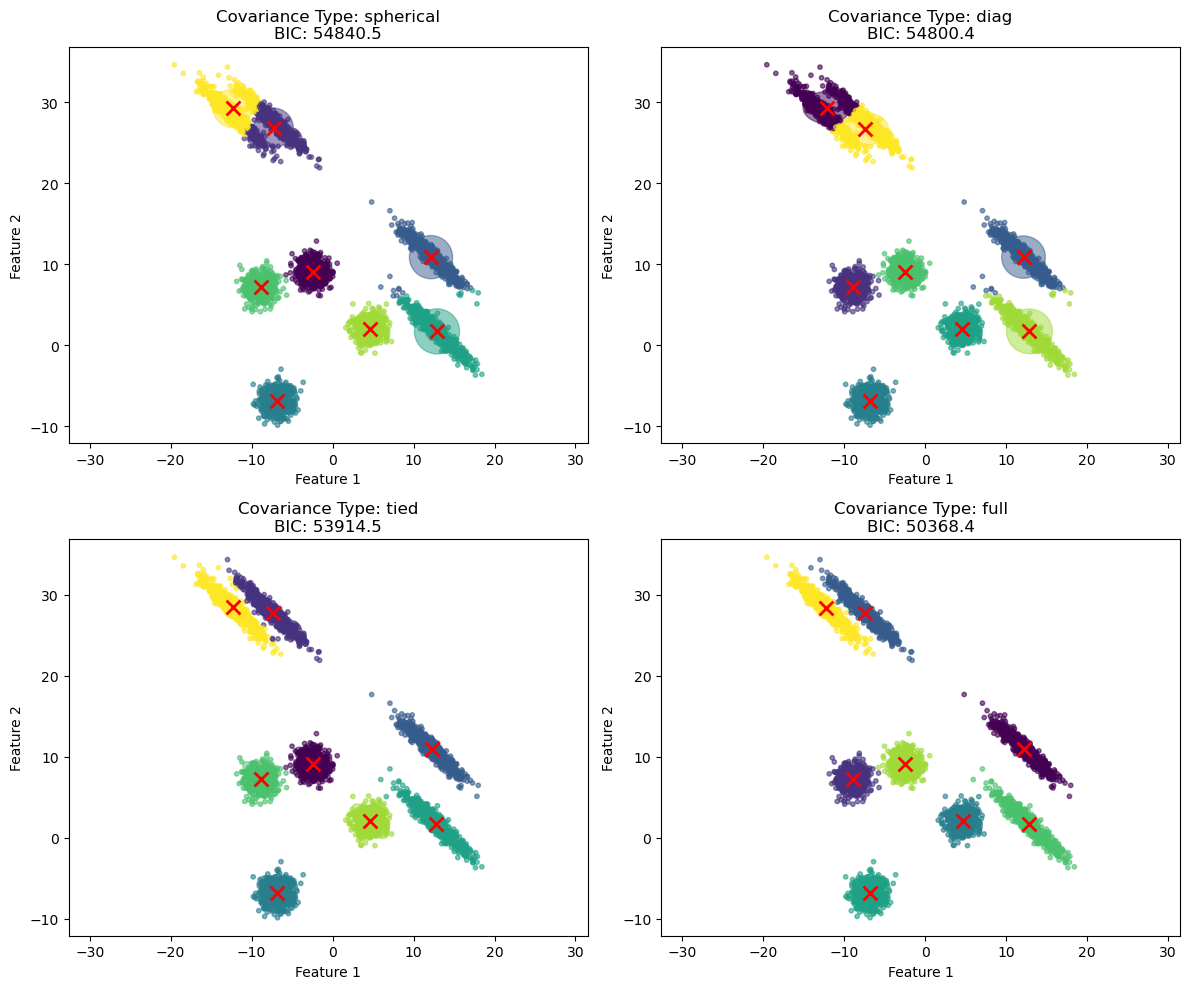


Gaussian Mixture Model analysis completed!


In [16]:
print("\n" + "="*60)
print("COMPARING DIFFERENT COVARIANCE TYPES")
print("="*60)

covariance_types = ['spherical', 'diag', 'tied', 'full']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, cov_type in enumerate(covariance_types):
    ax = axes[idx]

    # Fit GMM with optimal components
    gmm = GaussianMixture(
        n_components=optimal_components,
        covariance_type=cov_type,
        random_state=42,
        n_init=10
    )
    gmm.fit(x)

    # Plot data and predictions
    labels = gmm.predict(x)
    ax.scatter(x[:, 0], x[:, 1], c=labels, cmap='viridis', s=10, alpha=0.6)

    # Add ellipses
    gmm_analyzer.make_ellipses(gmm, ax)

    # Add centers
    ax.scatter(gmm.means_[:, 0], gmm.means_[:, 1],
               c='red', marker='x', s=100, linewidths=2)

    ax.set_title(f'Covariance Type: {cov_type}\nBIC: {gmm.bic(x):.1f}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_aspect('equal', 'datalim')

plt.tight_layout()
plt.show()

print("\nGaussian Mixture Model analysis completed!")

### Comparison of GaussianMixture Covariance Types

#### Covariance Type: `spherical`
- All clusters are forced to be circular with no orientation.
- Cannot capture elongated or oriented clusters.
- **BIC:** Highest (worst fit).

#### Covariance Type: `diag`
- Clusters can be elliptical but are always aligned with the axes (no rotation).
- Better than spherical for axis-aligned data, but cannot model arbitrary orientations.
- **BIC:** Slightly better than spherical.

#### Covariance Type: `tied`
- All clusters share the same general covariance matrix (same shape, size, and orientation).
- Can capture orientation, but not differences in shape/size between clusters.
- **BIC:** Better than spherical and diag, but not as good as full.

#### Covariance Type: `full`
- Each cluster has its own general covariance matrix (arbitrary shape, size, and orientation).
- Best fits the true distribution of the data.
- **BIC:** Lowest (best fit).

---

#### **Conclusion**
The main difference between the distributions obtained with each covariance type is the flexibility in modeling the shape, size, and orientation of the clusters. The `full` type gives the best fit, while `spherical` is the most restrictive. This is reflected in the BIC scores and the visual fit of the clusters to the data.

## 5-5


PART 5-5: COMPARING TIED VS FULL COVARIANCE MODELS

Fitting GMM with 8 components and 'tied' covariance...
Fitting GMM with 8 components and 'full' covariance...

Number of samples with different labels: 11 (0.22%)


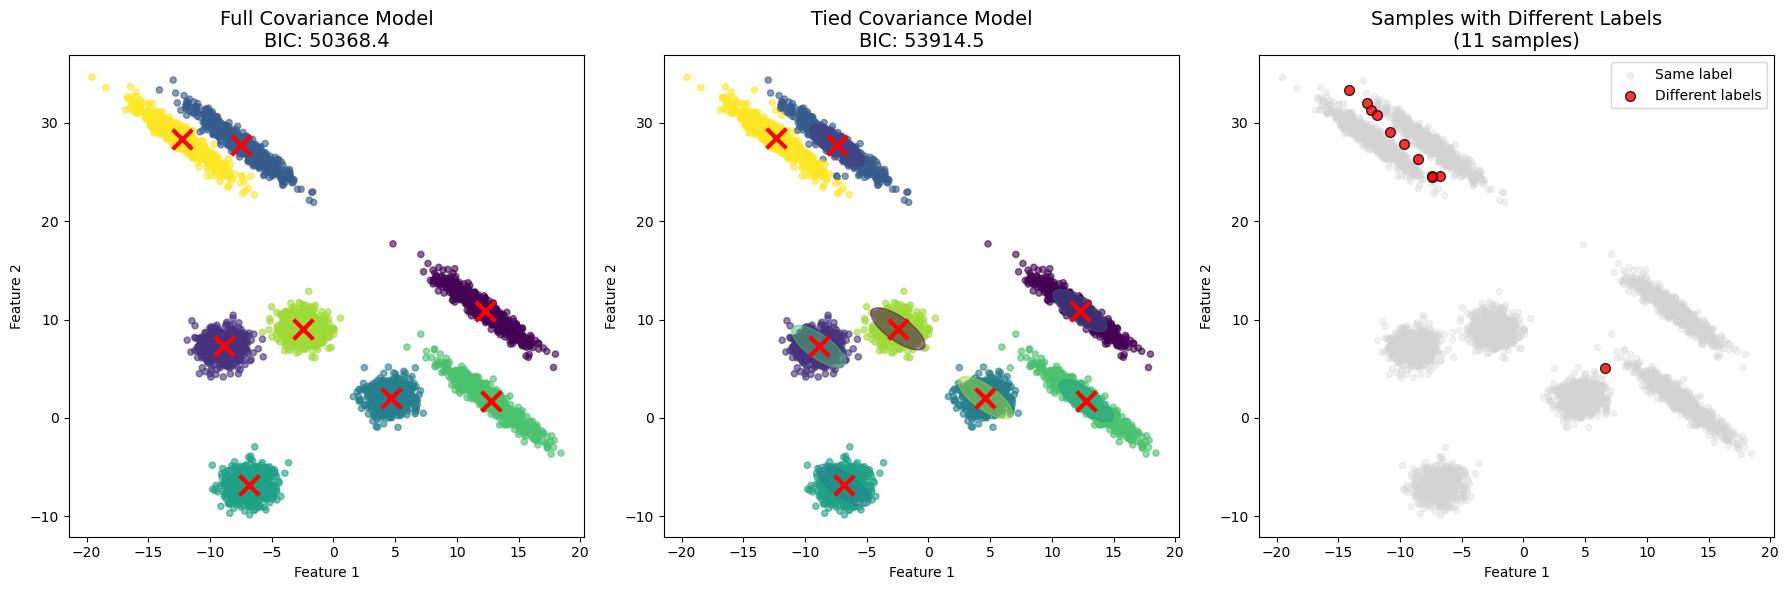

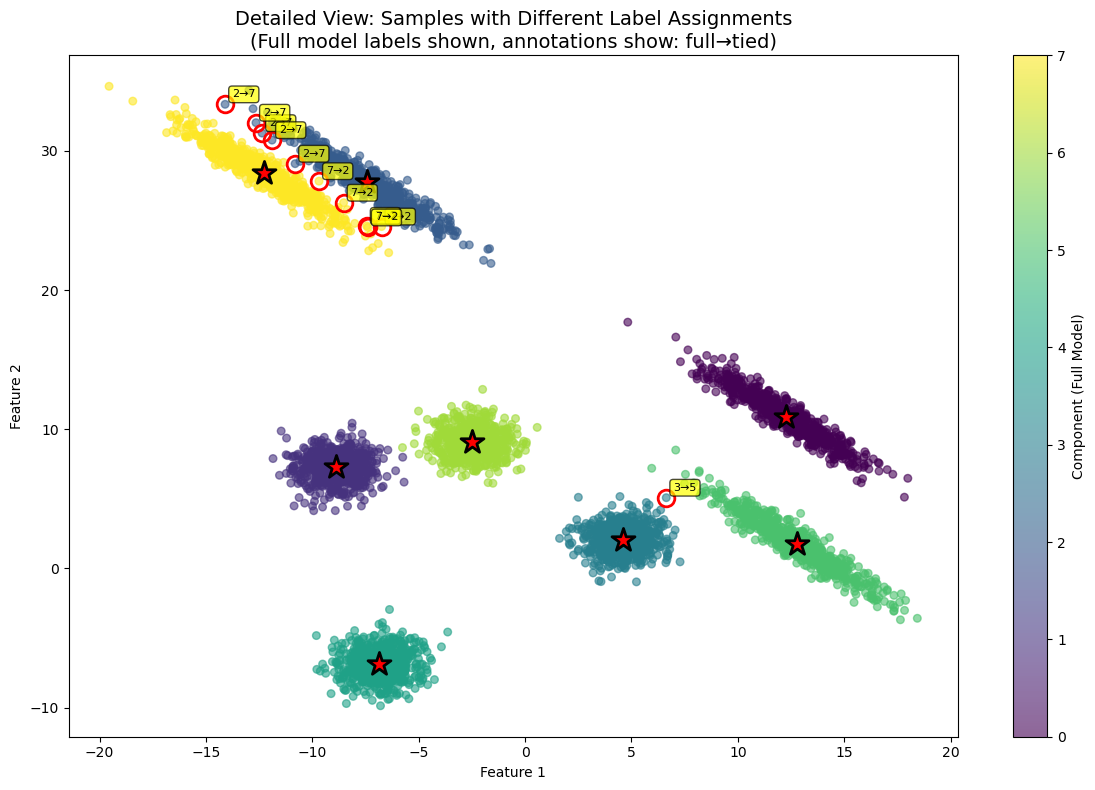


Analysis of label disagreements by component:
--------------------------------------------------
Component 0: 0/625 samples differ (0.0%)
Component 1: 0/625 samples differ (0.0%)
Component 2: 5/625 samples differ (0.8%)
Component 3: 1/625 samples differ (0.2%)
Component 4: 0/625 samples differ (0.0%)
Component 5: 0/625 samples differ (0.0%)
Component 6: 0/625 samples differ (0.0%)
Component 7: 5/625 samples differ (0.8%)

Probability analysis for samples with different labels (first 10):
--------------------------------------------------------------------------------
Sample   Full Label   Tied Label   Full Prob    Tied Prob   
--------------------------------------------------------------------------------
904      3            5            0.9919       0.0000      
2552     7            2            0.9954       0.0000      
2673     2            7            0.5071       0.7464      
3549     7            2            0.7766       0.0000      
3923     7            2            0.98

In [ ]:
from scipy.optimize import linear_sum_assignment


def compare_tied_vs_full_covariance(gmm_analyzer, optimal_components=8):
    """
    Compare GMM models with tied and full covariance types
    and find samples with different label assignments.
    """
    print("\n" + "="*60)
    print("PART 5-5: COMPARING TIED VS FULL COVARIANCE MODELS")
    print("="*60)

    # Fit GMM with tied covariance
    print(
        f"\nFitting GMM with {optimal_components} components and 'tied' covariance...")
    gmm_tied = GaussianMixture(
        n_components=optimal_components,
        covariance_type='tied',
        random_state=gmm_analyzer.random_state,
        n_init=10,
        max_iter=100
    )
    gmm_tied.fit(gmm_analyzer.data)
    labels_tied = gmm_tied.predict(gmm_analyzer.data)

    # Fit GMM with full covariance
    print(
        f"Fitting GMM with {optimal_components} components and 'full' covariance...")
    gmm_full = GaussianMixture(
        n_components=optimal_components,
        covariance_type='full',
        random_state=gmm_analyzer.random_state,
        n_init=10,
        max_iter=100
    )
    gmm_full.fit(gmm_analyzer.data)
    labels_full = gmm_full.predict(gmm_analyzer.data)

    # Align labels between the two models using Hungarian algorithm
    # This ensures that component labels are matched between models
    def align_labels(labels1, labels2):
        """Align labels between two clusterings using Hungarian algorithm."""
        n_clusters = len(np.unique(labels1))
        cost_matrix = np.zeros((n_clusters, n_clusters))

        for i in range(n_clusters):
            for j in range(n_clusters):
                # Cost is negative of the number of matching assignments
                cost_matrix[i, j] = -np.sum((labels1 == i) & (labels2 == j))

        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        # Create mapping
        label_mapping = {old_label: new_label for old_label,
                         new_label in zip(col_ind, row_ind)}

        # Apply mapping
        aligned_labels = np.array([label_mapping[label] for label in labels2])
        return aligned_labels

    # Align labels
    labels_tied_aligned = align_labels(labels_full, labels_tied)

    # Find samples with different labels
    different_mask = labels_full != labels_tied_aligned
    different_indices = np.where(different_mask)[0]
    n_different = len(different_indices)

    print(
        f"\nNumber of samples with different labels: {n_different} ({n_different/len(gmm_analyzer.data)*100:.2f}%)")

    if n_different > 0:
        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Plot 1: Full covariance model
        ax1 = axes[0]
        scatter1 = ax1.scatter(gmm_analyzer.data[:, 0], gmm_analyzer.data[:, 1],
                               c=labels_full, cmap='viridis', s=20, alpha=0.6)
        gmm_analyzer.make_ellipses(gmm_full, ax1)
        ax1.scatter(gmm_full.means_[:, 0], gmm_full.means_[:, 1],
                    c='red', marker='x', s=200, linewidths=3)
        ax1.set_title(
            f'Full Covariance Model\nBIC: {gmm_full.bic(gmm_analyzer.data):.1f}', fontsize=14)
        ax1.set_xlabel('Feature 1')
        ax1.set_ylabel('Feature 2')

        # Plot 2: Tied covariance model
        ax2 = axes[1]
        scatter2 = ax2.scatter(gmm_analyzer.data[:, 0], gmm_analyzer.data[:, 1],
                               c=labels_tied_aligned, cmap='viridis', s=20, alpha=0.6)
        gmm_analyzer.make_ellipses(gmm_tied, ax2)
        ax2.scatter(gmm_tied.means_[:, 0], gmm_tied.means_[:, 1],
                    c='red', marker='x', s=200, linewidths=3)
        ax2.set_title(
            f'Tied Covariance Model\nBIC: {gmm_tied.bic(gmm_analyzer.data):.1f}', fontsize=14)
        ax2.set_xlabel('Feature 1')
        ax2.set_ylabel('Feature 2')

        # Plot 3: Highlight different samples
        ax3 = axes[2]
        # Plot all points in light gray
        ax3.scatter(gmm_analyzer.data[:, 0], gmm_analyzer.data[:, 1],
                    c='lightgray', s=20, alpha=0.3, label='Same label')

        # Highlight points with different labels
        different_data = gmm_analyzer.data[different_mask]
        scatter3 = ax3.scatter(different_data[:, 0], different_data[:, 1],
                               c='red', s=50, alpha=0.8, edgecolors='black',
                               linewidth=1, label='Different labels')

        ax3.set_title(
            f'Samples with Different Labels\n({n_different} samples)', fontsize=14)
        ax3.set_xlabel('Feature 1')
        ax3.set_ylabel('Feature 2')
        ax3.legend()

        plt.tight_layout()
        plt.show()

        # Detailed comparison plot
        fig, ax = plt.subplots(figsize=(12, 8))

        # Plot all points with their full covariance labels
        scatter = ax.scatter(gmm_analyzer.data[:, 0], gmm_analyzer.data[:, 1],
                             c=labels_full, cmap='viridis', s=30, alpha=0.6)

        # Highlight different samples with markers showing both labels
        # Limit to 100 for clarity
        for idx in different_indices[:min(100, n_different)]:
            x, y = gmm_analyzer.data[idx]
            # Add a marker for the full model label
            ax.plot(x, y, 'o', markersize=12, markerfacecolor='none',
                    markeredgecolor='red', markeredgewidth=2)
            # Add text showing both labels
            ax.annotate(f'{labels_full[idx]}→{labels_tied_aligned[idx]}',
                        xy=(x, y), xytext=(5, 5), textcoords='offset points',
                        fontsize=8, bbox=dict(boxstyle="round,pad=0.3",
                                              facecolor="yellow", alpha=0.7))

        # Add ellipses for full model
        gmm_analyzer.make_ellipses(gmm_full, ax)

        # Add centers
        ax.scatter(gmm_full.means_[:, 0], gmm_full.means_[:, 1],
                   c='red', marker='*', s=300, linewidths=2, edgecolors='black')

        ax.set_title('Detailed View: Samples with Different Label Assignments\n' +
                     f'(Full model labels shown, annotations show: full→tied)', fontsize=14)
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')

        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Component (Full Model)')

        plt.tight_layout()
        plt.show()

        # Analyze which components have the most disagreement
        print("\nAnalysis of label disagreements by component:")
        print("-" * 50)
        for comp in range(optimal_components):
            comp_mask = labels_full == comp
            n_comp = np.sum(comp_mask)
            n_diff_comp = np.sum(comp_mask & different_mask)
            if n_comp > 0:
                print(
                    f"Component {comp}: {n_diff_comp}/{n_comp} samples differ ({n_diff_comp/n_comp*100:.1f}%)")

        # Show probability differences for some samples
        print("\nProbability analysis for samples with different labels (first 10):")
        print("-" * 80)
        print(
            f"{'Sample':<8} {'Full Label':<12} {'Tied Label':<12} {'Full Prob':<12} {'Tied Prob':<12}")
        print("-" * 80)

        # Get probabilities for each model
        probs_full = gmm_full.predict_proba(gmm_analyzer.data)
        probs_tied = gmm_tied.predict_proba(gmm_analyzer.data)

        for i, idx in enumerate(different_indices[:10]):
            full_label = labels_full[idx]
            tied_label = labels_tied_aligned[idx]
            full_prob = probs_full[idx, full_label]
            tied_prob = probs_tied[idx, tied_label]

            print(
                f"{idx:<8} {full_label:<12} {tied_label:<12} {full_prob:<12.4f} {tied_prob:<12.4f}")

    else:
        print("\nNo samples with different labels found!")
        print("The two models produce identical classifications.")

    # Model comparison statistics
    print("\n" + "="*60)
    print("MODEL COMPARISON SUMMARY")
    print("="*60)
    print(f"Full covariance BIC: {gmm_full.bic(gmm_analyzer.data):.2f}")
    print(f"Tied covariance BIC: {gmm_tied.bic(gmm_analyzer.data):.2f}")
    print(
        f"BIC difference: {gmm_full.bic(gmm_analyzer.data) - gmm_tied.bic(gmm_analyzer.data):.2f}")
    print(f"Number of parameters - Full: {gmm_full._n_parameters()}")
    print(f"Number of parameters - Tied: {gmm_tied._n_parameters()}")

    return gmm_full, gmm_tied, different_indices


# Run the analysis
gmm_full, gmm_tied, different_samples = compare_tied_vs_full_covariance(
    gmm_analyzer, optimal_components=8)

## 5-6


PART 5-6: TEST POINT ANALYSIS AND LIKELIHOOD COMPARISON

Fitting GMM with 8 components and 'full' covariance...

Test point (-20, 0) analysis:
  Most likely component: 1
  Probability for component 1: 1.000000
  Log-likelihood: -93.571811

Number of samples in component 1: 625

Least likely sample in component 1:
  Coordinates: (-11.46, 9.87)
  Log-likelihood: -10.751716
  Probability for component 1: 1.000000


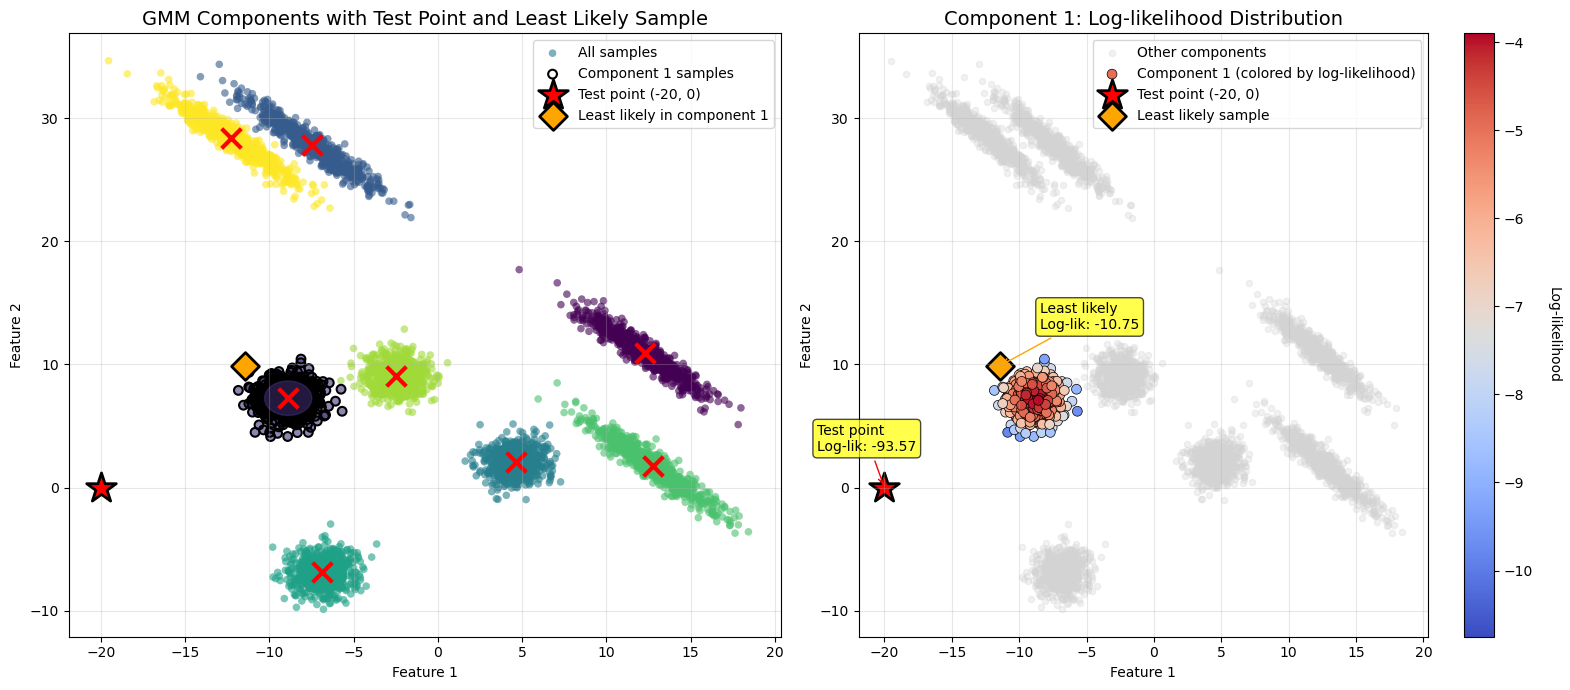


DETAILED COMPARISON: Test Point vs Least Likely Sample
            Metric Test Point (-20, 0) Least Likely Sample
       Coordinates      (-20.00, 0.00)      (-11.46, 9.87)
         Component                   1                   1
    Log-likelihood          -93.571811          -10.751716
    P(Component 1)            1.000000            1.000000
Distance to center               13.27                3.67

------------------------------------------------------------
PROBABILITY DISTRIBUTION ACROSS ALL COMPONENTS
------------------------------------------------------------

Test Point (-20, 0):
  Component 1: 1.000000

Least Likely Sample in Component 1:
  Component 1: 1.000000


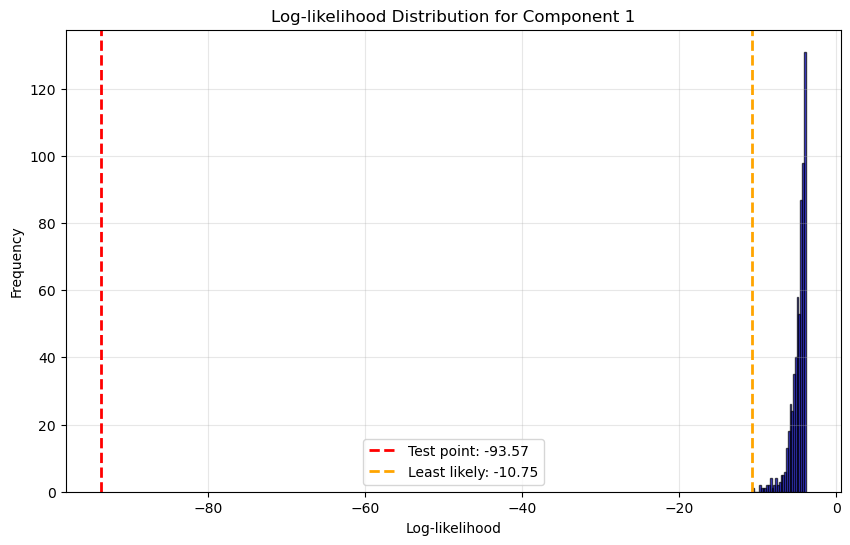

In [19]:
def analyze_test_point_and_likelihood(gmm_analyzer, optimal_components=8):
    """
    Part 5-6: Analyze test point (-20, 0) and find least likely sample in same component
    """
    print("\n" + "="*60)
    print("PART 5-6: TEST POINT ANALYSIS AND LIKELIHOOD COMPARISON")
    print("="*60)

    # Fit GMM with optimal components and full covariance
    print(
        f"\nFitting GMM with {optimal_components} components and 'full' covariance...")
    gmm = GaussianMixture(
        n_components=optimal_components,
        covariance_type='full',
        random_state=gmm_analyzer.random_state,
        n_init=10,
        max_iter=100
    )
    gmm.fit(gmm_analyzer.data)

    # Define test point
    test_point = np.array([[-20, 0]])

    # Predict component for test point
    test_label = gmm.predict(test_point)[0]
    test_proba = gmm.predict_proba(test_point)[0]
    test_log_likelihood = gmm.score_samples(test_point)[0]

    print(f"\nTest point (-20, 0) analysis:")
    print(f"  Most likely component: {test_label}")
    print(
        f"  Probability for component {test_label}: {test_proba[test_label]:.6f}")
    print(f"  Log-likelihood: {test_log_likelihood:.6f}")

    # Get all data points with the same label
    all_labels = gmm.predict(gmm_analyzer.data)
    same_component_mask = all_labels == test_label
    same_component_indices = np.where(same_component_mask)[0]
    same_component_data = gmm_analyzer.data[same_component_mask]

    print(
        f"\nNumber of samples in component {test_label}: {len(same_component_data)}")

    # Calculate log-likelihood for all samples in the same component
    log_likelihoods = gmm.score_samples(same_component_data)

    # Find the sample with minimum log-likelihood
    min_likelihood_idx = np.argmin(log_likelihoods)
    min_likelihood_sample = same_component_data[min_likelihood_idx]
    min_likelihood_value = log_likelihoods[min_likelihood_idx]
    min_likelihood_global_idx = same_component_indices[min_likelihood_idx]

    # Get probabilities for the least likely sample
    min_likelihood_proba = gmm.predict_proba(
        min_likelihood_sample.reshape(1, -1))[0]

    print(f"\nLeast likely sample in component {test_label}:")
    print(
        f"  Coordinates: ({min_likelihood_sample[0]:.2f}, {min_likelihood_sample[1]:.2f})")
    print(f"  Log-likelihood: {min_likelihood_value:.6f}")
    print(
        f"  Probability for component {test_label}: {min_likelihood_proba[test_label]:.6f}")

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # Plot 1: Overall view with all components
    labels = gmm.predict(gmm_analyzer.data)
    scatter1 = ax1.scatter(gmm_analyzer.data[:, 0], gmm_analyzer.data[:, 1],
                           c=labels, cmap='viridis', s=30, alpha=0.6,
                           edgecolors='none', label='All samples')

    # Highlight samples in the same component as test point
    ax1.scatter(same_component_data[:, 0], same_component_data[:, 1],
                c='none', edgecolors='black', linewidths=1.5, s=40,
                label=f'Component {test_label} samples')

    # Add test point
    ax1.scatter(test_point[0, 0], test_point[0, 1],
                c='red', marker='*', s=500, edgecolors='black', linewidth=2,
                label='Test point (-20, 0)', zorder=5)

    # Add least likely sample
    ax1.scatter(min_likelihood_sample[0], min_likelihood_sample[1],
                c='orange', marker='D', s=200, edgecolors='black', linewidth=2,
                label=f'Least likely in component {test_label}', zorder=5)

    # Add ellipses
    gmm_analyzer.make_ellipses(gmm, ax1)

    # Add component centers
    ax1.scatter(gmm.means_[:, 0], gmm.means_[:, 1],
                c='red', marker='x', s=200, linewidths=3)

    ax1.set_title(
        'GMM Components with Test Point and Least Likely Sample', fontsize=14)
    ax1.set_xlabel('Feature 1')
    ax1.set_ylabel('Feature 2')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Focused view on component with test point
    ax2.scatter(gmm_analyzer.data[:, 0], gmm_analyzer.data[:, 1],
                c='lightgray', s=20, alpha=0.3, label='Other components')

    # Color code by log-likelihood within the component
    scatter2 = ax2.scatter(same_component_data[:, 0], same_component_data[:, 1],
                           c=log_likelihoods, cmap='coolwarm', s=50,
                           edgecolors='black', linewidth=0.5,
                           label=f'Component {test_label} (colored by log-likelihood)')

    # Add test point
    ax2.scatter(test_point[0, 0], test_point[0, 1],
                c='red', marker='*', s=500, edgecolors='black', linewidth=2,
                label='Test point (-20, 0)')

    # Add least likely sample
    ax2.scatter(min_likelihood_sample[0], min_likelihood_sample[1],
                c='orange', marker='D', s=200, edgecolors='black', linewidth=2,
                label='Least likely sample')

    # Add annotations
    ax2.annotate(f'Test point\nLog-lik: {test_log_likelihood:.2f}',
                 xy=(test_point[0, 0], test_point[0, 1]),
                 xytext=(test_point[0, 0] - 5, test_point[0, 1] + 3),
                 arrowprops=dict(arrowstyle='->', color='red'),
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

    ax2.annotate(f'Least likely\nLog-lik: {min_likelihood_value:.2f}',
                 xy=(min_likelihood_sample[0], min_likelihood_sample[1]),
                 xytext=(min_likelihood_sample[0] + 3,
                         min_likelihood_sample[1] + 3),
                 arrowprops=dict(arrowstyle='->', color='orange'),
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

    # Add colorbar
    cbar = plt.colorbar(scatter2, ax=ax2)
    cbar.set_label('Log-likelihood', rotation=270, labelpad=20)

    ax2.set_title(
        f'Component {test_label}: Log-likelihood Distribution', fontsize=14)
    ax2.set_xlabel('Feature 1')
    ax2.set_ylabel('Feature 2')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Detailed comparison table
    print("\n" + "="*60)
    print("DETAILED COMPARISON: Test Point vs Least Likely Sample")
    print("="*60)

    # Create comparison data
    comparison_data = {
        'Metric': ['Coordinates', 'Component', 'Log-likelihood',
                   f'P(Component {test_label})', 'Distance to center'],
        'Test Point (-20, 0)': [
            f"({test_point[0, 0]:.2f}, {test_point[0, 1]:.2f})",
            test_label,
            f"{test_log_likelihood:.6f}",
            f"{test_proba[test_label]:.6f}",
            f"{np.linalg.norm(test_point - gmm.means_[test_label]):.2f}"
        ],
        'Least Likely Sample': [
            f"({min_likelihood_sample[0]:.2f}, {min_likelihood_sample[1]:.2f})",
            test_label,
            f"{min_likelihood_value:.6f}",
            f"{min_likelihood_proba[test_label]:.6f}",
            f"{np.linalg.norm(min_likelihood_sample - gmm.means_[test_label]):.2f}"
        ]
    }

    import pandas as pd
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))

    # Probability distribution across all components
    print("\n" + "-"*60)
    print("PROBABILITY DISTRIBUTION ACROSS ALL COMPONENTS")
    print("-"*60)

    print("\nTest Point (-20, 0):")
    for i in range(optimal_components):
        if test_proba[i] > 0.001:  # Only show significant probabilities
            print(f"  Component {i}: {test_proba[i]:.6f}")

    print(f"\nLeast Likely Sample in Component {test_label}:")
    for i in range(optimal_components):
        # Only show significant probabilities
        if min_likelihood_proba[i] > 0.001:
            print(f"  Component {i}: {min_likelihood_proba[i]:.6f}")

    # Additional analysis: Show log-likelihood distribution
    plt.figure(figsize=(10, 6))

    plt.hist(log_likelihoods, bins=30, alpha=0.7,
             color='blue', edgecolor='black')
    plt.axvline(test_log_likelihood, color='red', linestyle='--', linewidth=2,
                label=f'Test point: {test_log_likelihood:.2f}')
    plt.axvline(min_likelihood_value, color='orange', linestyle='--', linewidth=2,
                label=f'Least likely: {min_likelihood_value:.2f}')

    plt.xlabel('Log-likelihood')
    plt.ylabel('Frequency')
    plt.title(f'Log-likelihood Distribution for Component {test_label}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return gmm, test_point, min_likelihood_sample, test_label


# Run the analysis
gmm, test_point, least_likely_sample, component_label = analyze_test_point_and_likelihood(
    gmm_analyzer, optimal_components=8
)

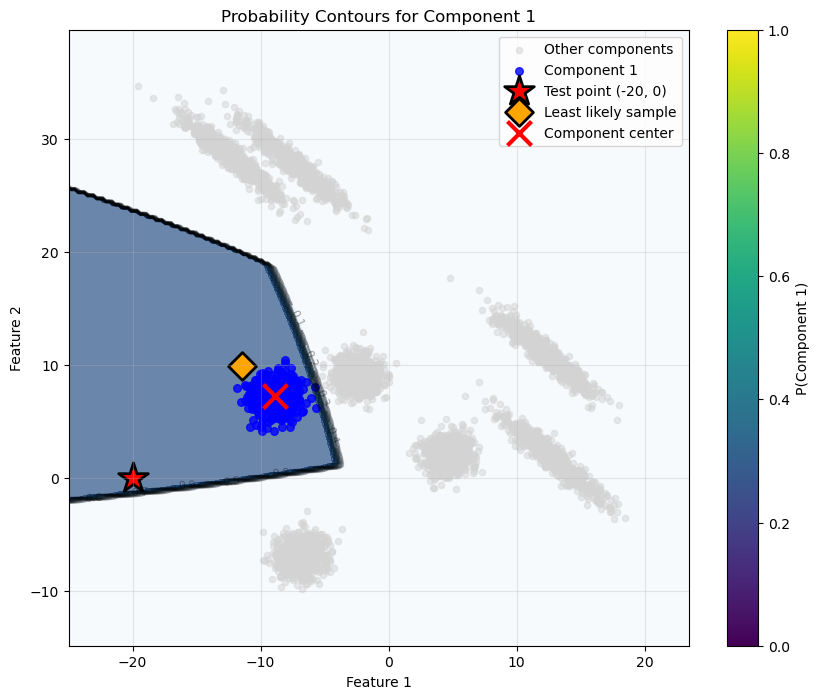

In [20]:
# Additional visualization: Probability contours

def plot_probability_contours_with_points(gmm, data, test_point, least_likely_sample, component_label):
    """
    Plot probability contours for the specific component containing the test point
    """
    plt.figure(figsize=(10, 8))

    # Create a mesh
    x_min, x_max = min(data[:, 0].min(), test_point[0, 0]
                       ) - 5, data[:, 0].max() + 5
    y_min, y_max = min(data[:, 1].min(), test_point[0, 1]
                       ) - 5, data[:, 1].max() + 5

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    # Calculate probabilities for the specific component
    positions = np.vstack([xx.ravel(), yy.ravel()]).T
    proba = gmm.predict_proba(positions)[:, component_label]
    proba = proba.reshape(xx.shape)

    # Plot contours
    contour = plt.contour(xx, yy, proba, levels=10, colors='black', alpha=0.4)
    plt.clabel(contour, inline=True, fontsize=8)

    # Filled contour
    plt.contourf(xx, yy, proba, levels=20, cmap='Blues', alpha=0.6)

    # Plot all data points
    labels = gmm.predict(data)
    component_mask = labels == component_label

    plt.scatter(data[~component_mask, 0], data[~component_mask, 1],
                c='lightgray', s=20, alpha=0.5, label='Other components')
    plt.scatter(data[component_mask, 0], data[component_mask, 1],
                c='blue', s=30, alpha=0.8, label=f'Component {component_label}')

    # Add special points
    plt.scatter(test_point[0, 0], test_point[0, 1],
                c='red', marker='*', s=500, edgecolors='black', linewidth=2,
                label='Test point (-20, 0)')
    plt.scatter(least_likely_sample[0], least_likely_sample[1],
                c='orange', marker='D', s=200, edgecolors='black', linewidth=2,
                label='Least likely sample')

    # Add component center
    plt.scatter(gmm.means_[component_label, 0], gmm.means_[component_label, 1],
                c='red', marker='x', s=300, linewidths=3, label='Component center')

    plt.colorbar(label=f'P(Component {component_label})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Probability Contours for Component {component_label}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


# Create the probability contour plot
plot_probability_contours_with_points(gmm, gmm_analyzer.data, test_point,
                                      least_likely_sample, component_label)